**Zyfra Technological Process for Gold Recovery**
---

### Introduction
---
This project focused on predicting recovery rates for the rougher and final output stages in the ore refining process. The workflow included data preparation, exploration, and cleaning—addressing anomalies and ensuring consistency between datasets—followed by the creation of feature and target datasets. Models were trained and evaluated using cross-validation with a custom weighted sMAPE metric to assess performance. Hyperparameter fine-tuning and baseline comparisons were performed, and the final selected Random Forest model was tested to ensure alignment between the training and test datasets. The final selected Random Forest model achieved a test sMAPE score of 5.79, outperforming the baseline constant model. This result indicates strong predictive performance and consistency between the training and test datasets.

### Importing libraries and datasets
---

In [126]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from numpy import mean, abs
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyRegressor
import warnings

In [127]:
warnings.filterwarnings("ignore")

In [ ]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [129]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


### Exploratory data analysis (EDA)
---


In [130]:
# Calculating recovery and MAE
# Recovery = (C * (F - T)) / (F * (C - T)) * 100 , where columns C = 47  |  F = 39  |  T = 52

C = gold_recovery_train['rougher.output.concentrate_au']
F = gold_recovery_train['rougher.input.feed_au']
T = gold_recovery_train['rougher.output.tail_au']
calculated_recovery = (C * (F - T)) / (F * (C - T)) * 100
actual_recovery = gold_recovery_train['rougher.output.recovery']

MAE = (calculated_recovery - actual_recovery).abs().mean()

print("MAE:", MAE)

MAE: 9.303415616264301e-15


###
1) To calculate recovery, the formula (C×(F−T))/(F×(C−T))*100 was used. The resulting value, referred to as calculated_recovery, was compared to the actual_recovery provided in the training dataset under the column rougher.output.recovery. The mean absolute error (MAE) was computed by taking the absolute difference between the calculated and actual recovery values and then finding the mean. The resulting MAE of 9.303415616264301e-15 is extremely small and nearly zero, indicating that the observations in rougher.output.recovery closely match the calculated values.
---

In [131]:
# Comparing differences between testing dataset and training dataset
missing_columns_dataset_test = set(
    (gold_recovery_train.columns)) - set((gold_recovery_test.columns))
print(missing_columns_dataset_test)

{'final.output.tail_sol', 'rougher.output.tail_ag', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb', 'final.output.tail_ag', 'rougher.calculation.au_pb_ratio', 'rougher.output.tail_pb', 'final.output.tail_pb', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.concentrate_pb', 'final.output.tail_au', 'final.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag', 'rougher.output.tail_au', 'rougher.output.concentrate_ag', 'final.output.recovery', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_sol', 'rougher.output.concentrate_sol', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.tail_sol', 'secondary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'rougher.outp

### 
2) The training dataset contains 34 features of float data type that are absent from the test dataset. This discrepancy occurs because certain parameters were measured or calculated at a later stage and were consequently excluded from the test dataset. The omitted features represent output and calculation metrics at various process stages, including rougher output concentrate, final output tail and concentrate, primary/secondary cleaner, and rougher calculations. Additionally, the target variables are excluded from the test dataset.
---

In [132]:
# Performing data preprocessing
print("FULL DATASET")
print("IS_NA:", gold_recovery_full.isnull().sum().sum())
print("ZERO VALUES:", (gold_recovery_full == 0).sum().sum())
print("DUPLICATED:", gold_recovery_full.duplicated().sum())
print()
print("TRAIN DATASET")
print("IS_NA:", gold_recovery_train.isnull().sum().sum())
print("ZERO VALUES:", (gold_recovery_train == 0).sum().sum())
print("DUPLICATED:", gold_recovery_train.duplicated().sum())
print()
print("TEST DATASET")
print("IS_NA:", gold_recovery_test.isnull().sum().sum())
print("ZERO VALUES:", (gold_recovery_test == 0).sum().sum())
print("DUPLICATED:", gold_recovery_test.duplicated().sum())

FULL DATASET
IS_NA: 36587
ZERO VALUES: 60015
DUPLICATED: 0

TRAIN DATASET
IS_NA: 30320
ZERO VALUES: 47571
DUPLICATED: 0

TEST DATASET
IS_NA: 2360
ZERO VALUES: 2450
DUPLICATED: 0


In [133]:
# Filling in missing values with the previous number
gold_recovery_full = gold_recovery_full.ffill()
gold_recovery_train = gold_recovery_train.ffill()
gold_recovery_test = gold_recovery_test.ffill()

print("FULL DATASET - CHECK NO MISSING VALUES")
print("IS_NA:", gold_recovery_train.isna().sum().sum())
print()
print("TRAIN DATASET - CHECK NO MISSING VALUES")
print("IS_NA:", gold_recovery_train.isnull().sum().sum())
print()
print("TEST DATASET - CHECK NO MISSING VALUES")
print("IS_NA:", gold_recovery_test.isnull().sum().sum())

FULL DATASET - CHECK NO MISSING VALUES
IS_NA: 0

TRAIN DATASET - CHECK NO MISSING VALUES
IS_NA: 0

TEST DATASET - CHECK NO MISSING VALUES
IS_NA: 0


### 
3) The data preprocessing step revealed that each dataset contained null values across various columns, along with zero values. Zero values were retained while missing values were addressed using forward-filling. Since the datasets resemble a time-series process occurring in sequential steps, forward-filling was considered an appropriate approach. Duplicate entries were also examined, and none were found.
---

### Analyzing the data
---

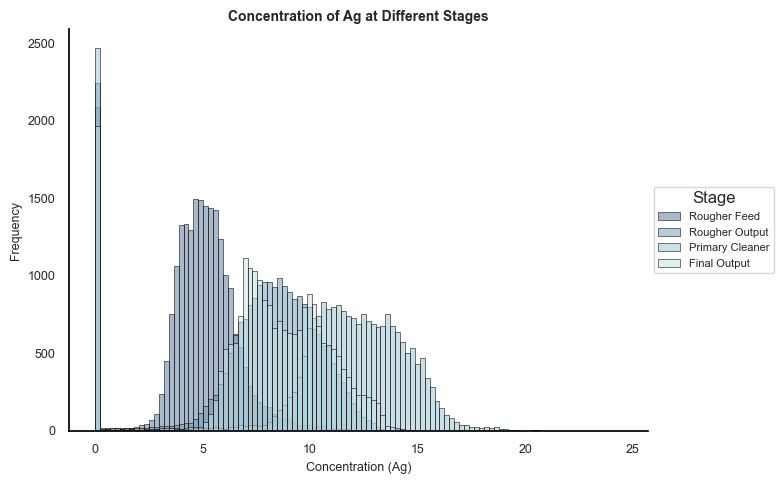

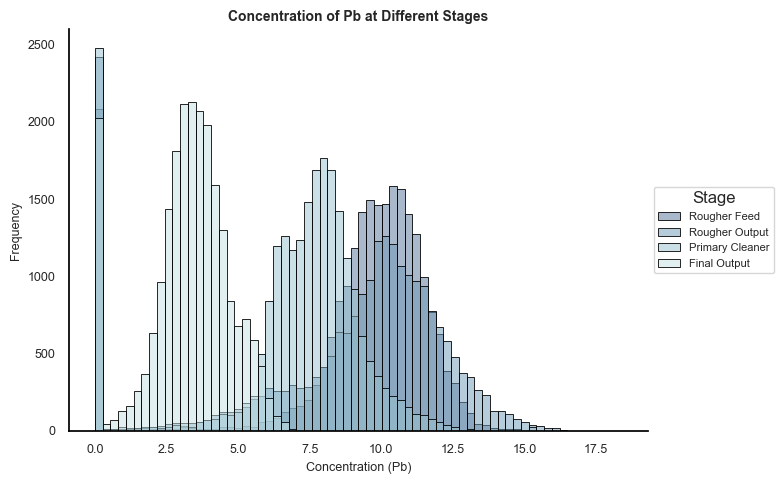

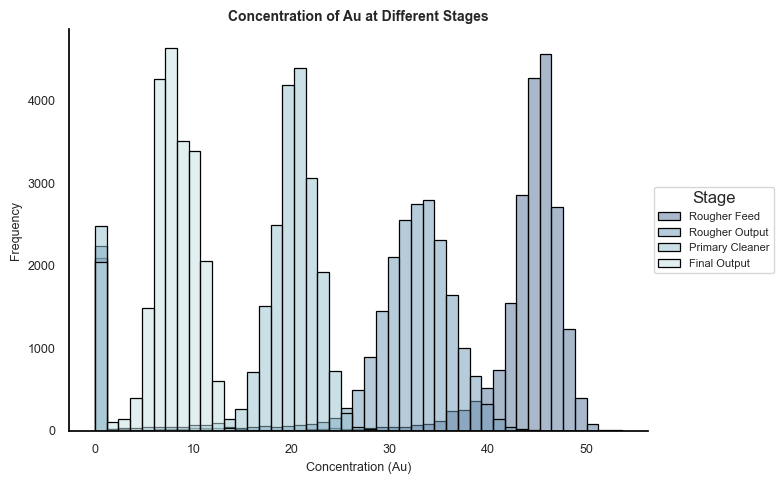

In [ ]:

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial",
                                   "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]


cube_palette = sns.cubehelix_palette(rot=-0.2, as_cmap=False)

# ----- Ag Histogram -----
data_ag = {
    'rougher.input.feed_ag': gold_recovery_full['rougher.input.feed_ag'],
    'rougher.output.concentrate_ag': gold_recovery_full['rougher.output.concentrate_ag'],
    'primary_cleaner.output.concentrate_ag': gold_recovery_full['primary_cleaner.output.concentrate_ag'],
    'final.output.concentrate_ag': gold_recovery_full['final.output.concentrate_ag']
}
ag_df = pd.DataFrame(data_ag)
ag_chart = ag_df.melt(var_name='Stages', value_name='Concentration')

plt.figure(figsize=(8, 5))
sns.histplot(data=ag_chart, x='Concentration', hue='Stages',
             palette=cube_palette, edgecolor='black')
plt.title('Concentration of Ag at Different Stages',
          fontsize=10, fontweight='bold')
plt.xlabel('Concentration (Ag)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title='Stage', labels=["Rougher Feed", "Rougher Output", "Primary Cleaner", "Final Output"],
           fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
plt.tight_layout()
plt.show()

# ----- Pb Histogram -----
data_pb = {
    'rougher.input.feed_pb': gold_recovery_full['rougher.input.feed_pb'],
    'rougher.output.concentrate_pb': gold_recovery_full['rougher.output.concentrate_pb'],
    'primary_cleaner.output.concentrate_pb': gold_recovery_full['primary_cleaner.output.concentrate_pb'],
    'final.output.concentrate_pb': gold_recovery_full['final.output.concentrate_pb']
}
pb_df = pd.DataFrame(data_pb)
pb_chart = pb_df.melt(var_name='Stages', value_name='Concentration')

plt.figure(figsize=(8, 5))
sns.histplot(data=pb_chart, x='Concentration', hue='Stages',
             palette=cube_palette, edgecolor='black')
plt.title('Concentration of Pb at Different Stages',
          fontsize=10, fontweight='bold')
plt.xlabel('Concentration (Pb)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title='Stage', labels=["Rougher Feed", "Rougher Output", "Primary Cleaner", "Final Output"],
           fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
plt.tight_layout()
plt.show()

# ----- Au Histogram -----
data_au = {
    'rougher.input.feed_au': gold_recovery_full['rougher.input.feed_au'],
    'rougher.output.concentrate_au': gold_recovery_full['rougher.output.concentrate_au'],
    'primary_cleaner.output.concentrate_au': gold_recovery_full['primary_cleaner.output.concentrate_au'],
    'final.output.concentrate_au': gold_recovery_full['final.output.concentrate_au']
}
au_df = pd.DataFrame(data_au)
au_chart = au_df.melt(var_name='Stages', value_name='Concentration')

plt.figure(figsize=(8, 5))
sns.histplot(data=au_chart, x='Concentration', hue='Stages',
             palette=cube_palette, edgecolor='black')
plt.title('Concentration of Au at Different Stages',
          fontsize=10, fontweight='bold')
plt.xlabel('Concentration (Au)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title='Stage', labels=["Rougher Feed", "Rougher Output", "Primary Cleaner", "Final Output"],
           fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
plt.tight_layout()
plt.show()


###
The concentration of substances varies throughout the stages of the process:

- ***Ag (Silver):*** The concentration begins lower in the rougher feed but remains consistently within the range of 5 to 15 across the subsequent three stages of the process.

- ***Pb (Lead):*** The concentration starts higher, at approximately 10, and gradually decreases to around 2.5 in the final output. The first three stages show some overlap in concentration, but this diminishes significantly in the final stage.

- ***Au (Gold):*** The concentration declines sharply from about 45 in the rougher feed to 5 in the final output, with minimal overlap observed between the stages.
--- 

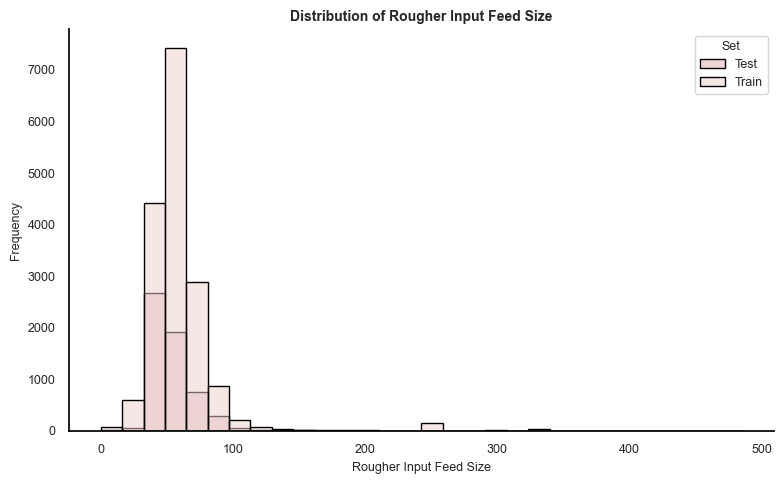

In [ ]:
# Comparing the feed particle size distributions in the training set versus the test set

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial",
                                   "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]
sns.set_theme(style="whitegrid")

data = {
    'Train': gold_recovery_train['rougher.input.feed_size'],
    'Test': gold_recovery_test['rougher.input.feed_size'],
}
ag_new = pd.DataFrame(data)
ag_chart_2 = ag_new.melt(var_name='Set', value_name='Concentration')

cube_palette = sns.cubehelix_palette(8)

plt.figure(figsize=(8, 5))
ax = plt.gca()
sns.histplot(data=ag_chart_2, x='Concentration', hue='Set', bins=30,
             edgecolor='black', palette=cube_palette, ax=ax)

plt.title('Distribution of Rougher Input Feed Size',
          fontsize=10, fontweight='bold')
plt.xlabel('Rougher Input Feed Size', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.legend(title='Set', labels=["Test", "Train"], fontsize=9, title_fontsize=9)

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

ax.grid(False)

plt.tight_layout()
plt.show()

###
2) Comparing the feed particle size distributions between the training and test datasets, both show a higher concentration within the 0–100 size range. The training dataset exhibits a greater concentration in this range compared to the test dataset, likely due to the larger number of observations in the training set.   
---

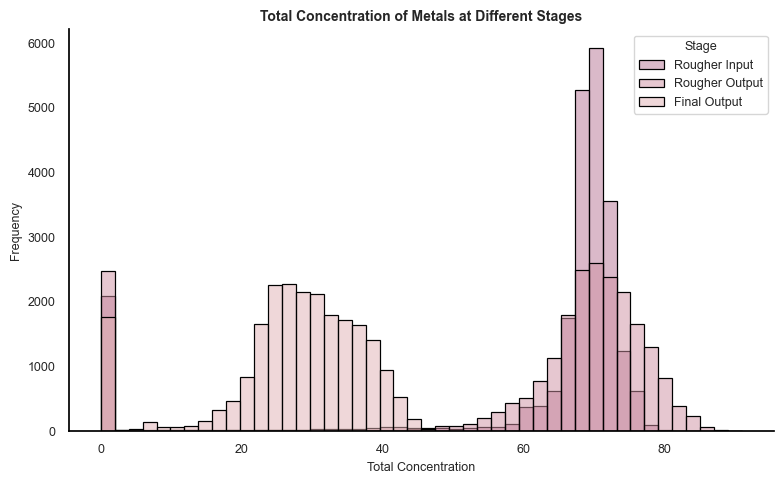

(22716, 90)


In [ ]:
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial",
                                   "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]
sns.set_theme(style="whitegrid")

cube_palette = sns.cubehelix_palette(dark=0.25, light=0.75)

rougher_input = ['rougher.input.feed_au',
                 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']
rougher_output = ['rougher.output.concentrate_au',
                  'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
final_cleaner_output = ['final.output.concentrate_au',
                        'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']

gold_recovery_full['rougher_input'] = (gold_recovery_full['rougher.input.feed_au'] +
                                       gold_recovery_full['rougher.input.feed_ag'] +
                                       gold_recovery_full['rougher.input.feed_pb'] +
                                       gold_recovery_full['final.output.concentrate_sol'])
gold_recovery_full['rougher_output'] = (gold_recovery_full['rougher.output.concentrate_au'] +
                                        gold_recovery_full['rougher.output.concentrate_ag'] +
                                        gold_recovery_full['rougher.output.concentrate_pb'] +
                                        gold_recovery_full['rougher.output.concentrate_sol'])
gold_recovery_full['final_cleaner_output'] = (gold_recovery_full['final.output.concentrate_au'] +
                                              gold_recovery_full['final.output.concentrate_ag'] +
                                              gold_recovery_full['final.output.concentrate_pb'] +
                                              gold_recovery_full['final.output.concentrate_sol'])

data = {
    'rougher_input': gold_recovery_full['rougher_input'],
    'rougher_output': gold_recovery_full['rougher_output'],
    'final_cleaner_output': gold_recovery_full['final_cleaner_output']
}
ag_combined = pd.DataFrame(data)
ag_chart_combined = ag_combined.melt(
    var_name='Stages', value_name='Concentration')

plt.figure(figsize=(8, 5))
ax = plt.gca()
sns.histplot(data=ag_chart_combined, x='Concentration', hue='Stages',
             palette=cube_palette, edgecolor='black', ax=ax)

plt.title('Total Concentration of Metals at Different Stages',
          fontsize=10, fontweight='bold')
plt.xlabel('Total Concentration', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title='Stage', labels=["Rougher Input", "Rougher Output", "Final Output"],
           fontsize=9, title_fontsize=9)

ax.grid(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(gold_recovery_full.shape)

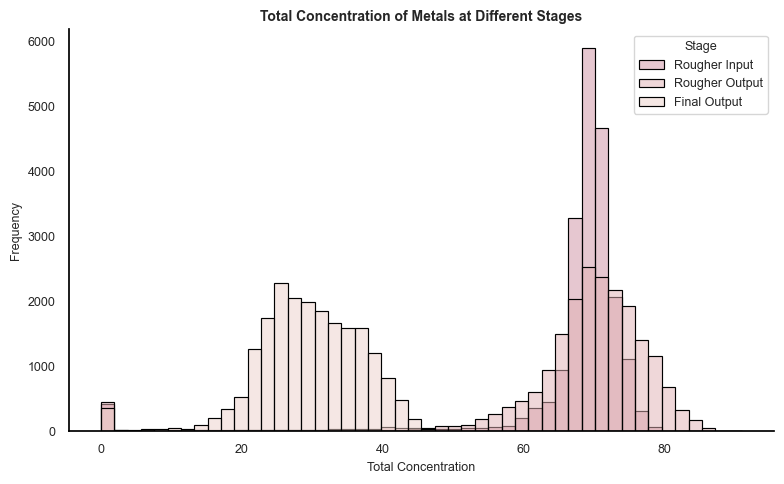

(20475, 90)


In [ ]:

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial",
                                   "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]
sns.set_theme(style="whitegrid")


cube_palette = sns.cubehelix_palette(8)

# Eliminating anomalies
Threshold = 0.01

gold_recovery_full = gold_recovery_full[
    (gold_recovery_full['rougher_input'] > Threshold) &
    (gold_recovery_full['rougher_output'] > Threshold) &
    (gold_recovery_full['final_cleaner_output'] > Threshold)
]

gold_recovery_full_filtered = gold_recovery_full[
    (gold_recovery_full['rougher_input'] > Threshold) &
    (gold_recovery_full['rougher_output'] > Threshold) &
    (gold_recovery_full['final_cleaner_output'] > Threshold)
]

data = {
    'rougher_input': gold_recovery_full_filtered['rougher_input'],
    'rougher_output': gold_recovery_full_filtered['rougher_output'],
    'final_cleaner_output': gold_recovery_full_filtered['final_cleaner_output']
}
ag_combined = pd.DataFrame(data)


ag_chart_combined = ag_combined.melt(
    var_name='Stages', value_name='Concentration')


plt.figure(figsize=(8, 5))
ax = plt.gca()
sns.histplot(data=ag_chart_combined, x='Concentration', hue='Stages',
             palette=cube_palette, edgecolor='black', ax=ax)


plt.title('Total Concentration of Metals at Different Stages',
          fontsize=10, fontweight='bold')
plt.xlabel('Total Concentration', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.legend(title='Stage', labels=["Rougher Input", "Rougher Output", "Final Output"],
           fontsize=9, title_fontsize=9)

ax.grid(False)

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

gold_recovery_full = gold_recovery_full.reset_index(drop=True)
print(gold_recovery_full.shape)

###
3) Plotting the total concentration of all substances at different stages reveals a significant number of near-zero values. Zeros may result from measurement errors and should be removed to avoid adverse effects on the analysis. A threshold of 0.01 was defined, and any value below this threshold was eliminated from the datasets. After addressing these anomalies, the total count of zero values decreased, as confirmed by the updated shapes of the datasets and charts.
--- 

In [138]:
print('FULL SET SHAPE:', gold_recovery_full.shape)
print('TRAIN SET SHAPE:', gold_recovery_train.shape)

gold_recovery_full = gold_recovery_full.drop(
    ['rougher_input', 'rougher_output', 'final_cleaner_output'], axis=1)
gold_recovery_train = gold_recovery_train.merge(
    gold_recovery_full[['date']], on='date', how='inner')

print('FULL SET AFTER MERGE AND DROP COLUMNS SHAPE:', gold_recovery_full.shape)
print('TRAIN SET AFTER MERGE AND DROP COLUMNS SHAPE:', gold_recovery_train.shape)

gold_recovery_train = gold_recovery_train.reset_index(drop=True)

FULL SET SHAPE: (20475, 90)
TRAIN SET SHAPE: (16860, 87)
FULL SET AFTER MERGE AND DROP COLUMNS SHAPE: (20475, 87)
TRAIN SET AFTER MERGE AND DROP COLUMNS SHAPE: (15165, 87)


###
4) Before model building, adjustments were applied to both the full and train datasets. Initially, the three columns used for calculating total concentration in the previous step were removed. Because rows in the full dataset had been eliminated based on the threshold check and the index reset, the train set required updating. An inner join was performed between the train set and the full dataset using the date column, ensuring that only rows with matching date values in both datasets were retained and no new rows were added. Examining the shapes of both datasets confirmed that they now have the same number of columns, no additional rows were added to the full dataset, and rows were correctly removed from the train set.
--- 

### Building the model
---

In [139]:
# Defining the features and target datasets to train different models
features_train = gold_recovery_train.drop(
    columns=list(missing_columns_dataset_test)+['date'], axis=1)
target_train = gold_recovery_train[[
    'final.output.recovery', 'rougher.output.recovery']]

print(features_train.shape)
print(target_train.shape)

(15165, 52)
(15165, 2)


###
1) The features and target training datasets have been created. The training dataset had its index reset after rows were removed based on the threshold adjustment for anomalies in the previous step. For the features dataset, the date column and the columns identified in missing_columns_dataset_test were removed. These latter columns comprise those present in gold_recovery_train but absent in gold_recovery_test, as determined earlier. This step ensures consistency between the training and test datasets, which is essential for model evaluation. The target dataset was constructed using the output recovery values for the rougher and final stages. Both datasets have the same number of observations, confirming alignment. Model building can now proceed.
---

In [140]:
# Defining function for final sMAPE
# sMAPE = 1/n x Σ(|Prediction - Actual| / ((|Actual| + |Prediction|) / 2) x 100
# final sMAPE = 0.25 * sMAPE(rougher) + 0.75 * sMAPE(final)

def weighted_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Add a small constant to the denominator to avoid division by zero
    epsilon = 1e-10

    rougher_denominator = (abs(y_true[:, 0]) + abs(y_pred[:, 0])) / 2 + epsilon
    smape_rougher = mean(
        abs(y_true[:, 0] - y_pred[:, 0]) / rougher_denominator) * 100

    final_denominator = (abs(y_true[:, 1]) + abs(y_pred[:, 1])) / 2 + epsilon
    smape_final = mean(
        abs(y_true[:, 1] - y_pred[:, 1]) / final_denominator) * 100

    return 0.25 * smape_rougher + 0.75 * smape_final


###
2) The weighted_smape function calculates sMAPE (Symmetric Mean Absolute Percentage Error) using true values (target) and model predictions. A small constant epsilon is added to the denominator to prevent division by zero. The target comprises two columns—'final.output.recovery' and 'rougher.output.recovery'—and the function processes each by referencing their respective positions in the array (0 or 1). The function returns an overall sMAPE that combines the rougher and final sMAPE values. Unlike Mean Absolute Error (MAE), sMAPE expresses errors as relative percentages rather than absolute values, thereby accounting for the scale of both target and predictions.
---

In [142]:
# Testing different model using cross-validation technique: (1) Decision Tree, (2) Random Forest, and (3) Linear Regression

# Decision Tree:
smape_scorer = make_scorer(weighted_smape, greater_is_better=True)
model_decision_tree = MultiOutputRegressor(
    DecisionTreeRegressor(random_state=12345))
score_tree = cross_val_score(
    model_decision_tree, features_train, target_train, cv=3, scoring=smape_scorer)
print('sMAPE Decision Tree Model Scores:', score_tree)
print('sMAPE Average Decision Tree Model Score:', np.mean(score_tree))
print()

# Random Forest:
smape_scorer = make_scorer(weighted_smape, greater_is_better=True)
model_random_forest = MultiOutputRegressor(
    RandomForestRegressor(random_state=12345))
score_random = cross_val_score(
    model_random_forest, features_train, target_train, cv=3, scoring=smape_scorer)
print('sMAPE Random Forest Model Scores:', score_random)
print('sMAPE Average Random Forest Model Score:', np.mean(score_random))
print()

# Linear Regression:
smape_scorer = make_scorer(weighted_smape, greater_is_better=True)
model_linear_regression = MultiOutputRegressor(LinearRegression())
score_linear = cross_val_score(
    model_linear_regression, features_train, target_train, cv=3, scoring=smape_scorer)
print('sMAPE Linear Regression Model Scores:', score_linear)
print('sMAPE Average Linear Regression Model Score:', np.mean(score_linear))

sMAPE Decision Tree Model Scores: [67.13605075 11.65313042 15.60843659]
sMAPE Average Decision Tree Model Score: 31.465872589108525

sMAPE Random Forest Model Scores: [10.68275644  7.99411715 13.70313909]
sMAPE Average Random Forest Model Score: 10.793337560966705

sMAPE Linear Regression Model Scores: [ 9.9834985   7.33877752 18.3760715 ]
sMAPE Average Linear Regression Model Score: 11.899449176420907


###
3) Three models were evaluated: (1) Decision Tree, (2) Random Forest, and (3) Linear Regression. The Random Forest model emerged as the best performer, achieving the lowest final sMAPE with an average score of 10.79. Evaluation employed cross-validation with cv=3, using a custom scorer that references the weighted_smape function in cross_val_score from sklearn. During cross-validation, the dataset was automatically split into training and validation sets for each fold. Target values in the validation set were treated as the true values, while model predictions served as the estimated values. This process was repeated for both rougher and final outputs, with the final sMAPE calculated for each fold and the overall result obtained as the average sMAPE across the three folds.      
---

In [ ]:
# Enhancing model performance: optimizing hyperparameters

# Decision Tree:
best_score_decision_tree = 0

for depth in range(1, 5):
    smape_scorer = make_scorer(weighted_smape, greater_is_better=True)
    model_decision_tree = MultiOutputRegressor(
        DecisionTreeRegressor(max_depth=depth, random_state=12345))
    score_tree = cross_val_score(
        model_decision_tree, features_train, target_train, cv=3, scoring=smape_scorer)
    if np.mean(score_tree) > np.mean(best_score_decision_tree):
        best_score_decision_tree = score_tree
print(f"sMAPE Average Decision Tree Model Best Score: max_depth = {depth}, score: {
      best_score_decision_tree}, average score: {np.mean(best_score_decision_tree)}")
print()

# Random Forest:
best_score_random_forest = 0
best_est_random_forest = 0

for depth in range(1, 3):
    smape_scorer = make_scorer(weighted_smape, greater_is_better=True)
    model_random_forest = MultiOutputRegressor(
        RandomForestRegressor(max_depth=depth, random_state=12345))
    score_random = cross_val_score(
        model_random_forest, features_train, target_train, cv=3, scoring=smape_scorer)
    if np.mean(score_random) > np.mean(best_score_random_forest):
        best_score_random_forest = score_random
        best_deep_random_forest = depth

for est in range(1, 5):
    smape_scorer = make_scorer(weighted_smape, greater_is_better=True)
    model_random_forest = MultiOutputRegressor(RandomForestRegressor(
        max_depth=best_deep_random_forest, random_state=12345, n_estimators=est))
    score_random = cross_val_score(
        model_random_forest, features_train, target_train, cv=3, scoring=smape_scorer)
    if np.mean(score_random) > np.mean(best_score_random_forest):
        best_score_random_forest = score_random
        best_est_random_forest = est

print(f"sMAPE Average Random Forest Model Best Score: max_depth = {best_deep_random_forest}, n_estimators = {
      best_est_random_forest}, score: {best_score_random_forest}, average score: {np.mean(best_score_random_forest)}")
print()

sMAPE Average Decision Tree Model Best Score: max_depth = 4, score: [10.56665208  8.60785841 13.41580363], average score: 10.863438040538014

sMAPE Average Random Forest Model Best Score: max_depth = 1, n_estimators = 0, score: [11.24841196  8.41244829 12.53838886], average score: 10.733083037158005



###
4) Hyperparameter fine-tuning improved the performance of both models. The Random Forest's score improved to 10.73 (from 10.79 previously) while the Decision Tree model improved from 31.46 to 10.86. Consequently, the Random Forest was selected as the top model for evaluating the test dataset.
---

In [ ]:
# Formatting the test dataset to include the target columns

print('FULL SET SHAPE:', gold_recovery_full.shape)
print('TEST SET SHAPE:', gold_recovery_test.shape)

gold_recovery_test = gold_recovery_test.merge(gold_recovery_full[[
                                              'date', 'final.output.recovery', 'rougher.output.recovery']], on='date', how='inner')

print('FULL SET AFTER MERGE SHAPE:', gold_recovery_full.shape)
print('TEST SET AFTER MERGE SHAPE:', gold_recovery_test.shape)

gold_recovery_test = gold_recovery_test.reset_index(drop=True)

FULL SET SHAPE: (20475, 87)
TEST SET SHAPE: (5856, 53)
FULL SET AFTER MERGE SHAPE: (20475, 87)
TEST SET AFTER MERGE SHAPE: (5310, 55)


###
5) The test dataset required adjustments to include the target columns 'final.output.recovery' and 'rougher.output.recovery', which were initially absent. Merging the full dataset with the test dataset—adding only these two columns for observations with matching dates—achieved the necessary update.
--- 

In [ ]:
# Defining the features and target for the test set
features_test = gold_recovery_test.drop(
    columns=['date', 'final.output.recovery', 'rougher.output.recovery'], axis=1)
target_test = gold_recovery_test[[
    'final.output.recovery', 'rougher.output.recovery']]

print(features_test.shape)
print(target_test.shape)

(5310, 52)
(5310, 2)


###
6) The features and target test datasets were successfully created, and the shape function confirmed that the merged data contained the correct number of columns and rows.
---

In [ ]:
# Testing the best model (Random Forest) based on final sMAPE
smape_scorer = make_scorer(weighted_smape, greater_is_better=True)
model_random_forest_test = MultiOutputRegressor(RandomForestRegressor(
    max_depth=1, random_state=12345))
score_random_test = cross_val_score(
    model_random_forest_test, features_test, target_test, cv=3, scoring=smape_scorer)
print('sMAPE Random Forest Model Scores:', score_random_test)
print('sMAPE Average Random Forest Model Score:', np.mean(score_random_test))

sMAPE Random Forest Model Scores: [5.86667569 4.25917006 7.26075925]
sMAPE Average Random Forest Model Score: 5.795535003760083


In [ ]:
dummy = DummyRegressor(strategy='mean')
dummy_score = cross_val_score(
    dummy, features_train, target_train, cv=3, scoring=smape_scorer)
print('Dummy sMAPE score: ', dummy_score)
print('Mean: ', dummy_score.mean())

Dummy sMAPE score:  [11.00162068  7.23626399 13.11006054]
Mean:  10.449315068848195


###
7) The Random Forest model demonstrated consistent performance on both the training and test datasets, achieving a test score of 5.79—lower than the training score. For validation, a constant model was used as a baseline comparison; this model assigns the mean value to predictions and resulted in an average sMAPE score of 10.45. The higher score confirms that the Random Forest model outperformed the baseline, indicating superior predictive accuracy and consistency.
---

### Conclusion
--- 
The project focused on predicting the rougher and final output stages in the technological processing of mined ore. Model evaluation tested three approaches: Decision Tree, Random Forest, and Linear Regression. Among these, Random Forest was the best-performing model, achieving a training sMAPE of 10.79 and a test sMAPE of 5.79, which demonstrated consistent results between datasets. Cross-validation with a weighted sMAPE metric confirmed the reliability of the evaluation process by effectively accounting for scale differences in predictions and targets. The Random Forest model was ultimately chosen for final evaluation due to its superior performance.  